In [2]:
import numpy as np
import argparse
import imutils
import time
import cv2
import tensorflow as tf
from huggingface_hub import from_pretrained_keras
from imutils.object_detection import non_max_suppression
import matplotlib.pyplot as plt

/Users/thrilok/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


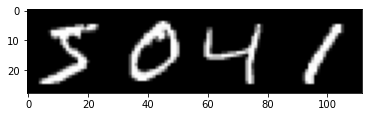

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

orig = np.zeros((28, 112))
orig[:, :28] = x_train[0]
orig[:, 28:56] = x_train[1]
orig[:, 56:84] = x_train[2]
orig[:, 84:] = x_train[3]
(H, W) = orig.shape[:2]
plt.imshow(orig, cmap='gray');

In [4]:
class SelectiveSearchObjectDetection():
    def __init__(self, pretrained_classifier_path, **kwargs):
        self.model = from_pretrained_keras(pretrained_classifier_path)
        self.kwargs = kwargs
        
    def selective_search(self, image, method="fast"):
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
        ss.setBaseImage(image)
        if method == "fast":
            ss.switchToSelectiveSearchFast()
        else:
            ss.switchToSelectiveSearchQuality()
        return ss.process()
    
    def get_rois_and_locs(self, rects):
        rois = []
        locs = []
        for (x, y, w, h) in rects:
            if w / float(W) < 0.1 or h / float(H) < 0.1:
                continue
            roi = orig[y:y + h, x:x + w]
            roi = cv2.resize(roi, self.kwargs['INPUT_SIZE'])
            rois.append(roi)
            locs.append((x, y, w, h))
        return rois, locs
    
    def visualize_rois(self, rois):
        fig, axes = plt.subplots(1, len(rois), figsize=(20, 6))
        for ax, roi in zip(axes, rois):
            ax.imshow(roi, cmap='gray')
            
    def get_preds(self, rois, locs):
        rois = np.array(rois, dtype="float32")
        preds = self.model.predict(rois)
        preds = list(zip(preds.argmax(axis=1).tolist(), preds.max(axis=1).tolist()))
        labels = {}

        for (i, p) in enumerate(preds):
            (label, prob) = p
            if prob >= self.kwargs['MIN_CONF']:
                box = locs[i]
                L = labels.get(label, [])
                L.append((box, prob))
                labels[label] = L
        return preds, labels
    
    def apply_nms(self, labels):
        nms_labels = {}
        for label in sorted(labels.keys()):
            boxes = np.array([p[0] for p in labels[label]])
            proba = np.array([p[1] for p in labels[label]])
            boxes = non_max_suppression(boxes, proba)
            nms_labels[label] = boxes.tolist()
        return nms_labels
            
    def visualize_preds(self, img, nms_labels):
        for label in sorted(nms_labels.keys()):
            clone = img.copy()
            fig, ax = plt.subplots(figsize=(20, 6))
            boxes = nms_labels[label]
            for (startX, startY, width, height) in boxes:
                cv2.rectangle(clone, (startX, startY), (startX+width, startY+height), (255, 255, 255), 1)
                y = startY - 10 if startY - 10 > 10 else startY + 10
                cv2.putText(clone, str(label), (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 1)

            ax.imshow(clone, cmap='gray')
            ax.set_title("After")
    
    def __call__(self, img):
        rects = self.selective_search(np.dstack([img, img, img]).astype(np.float32))
        rois, locs = self.get_rois_and_locs(rects)
        if self.kwargs['VIZ_ROIS']:
            self.visualize_rois(rois)
        preds, labels = self.get_preds(rois, locs)
        nms_labels = self.apply_nms(labels)
        
        if self.kwargs['VISUALIZE']:
            self.visualize_preds(img, nms_labels)
        return nms_labels

In [5]:
kwargs = dict(INPUT_SIZE=(28, 28), MIN_CONF=0.9, VISUALIZE=True, VIZ_ROIS=True)

config.json not found in HuggingFace Hub
2022-04-24 17:12:20.029376: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-24 17:12:20.030119: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


2022-04-24 17:12:23.979964: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-24 17:12:24.134645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Predictions:  {0: [[32, 2, 21, 24], [34, 3, 18, 22], [33, 3, 19, 22], [34, 4, 17, 20], [35, 5, 16, 18], [35, 4, 16, 19]], 1: [[90, 3, 18, 24], [91, 4, 16, 22]], 4: [[57, 3, 24, 24], [0, 0, 112, 28], [59, 5, 20, 20], [59, 5, 19, 21]], 5: [[3, 4, 22, 22]]}


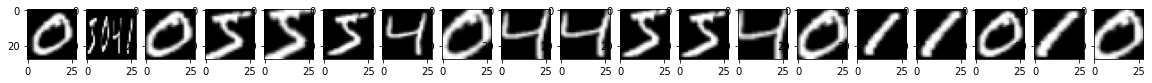

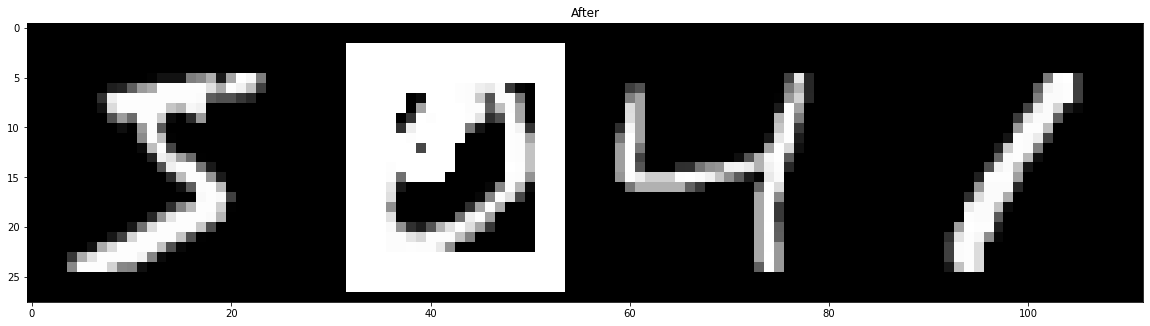

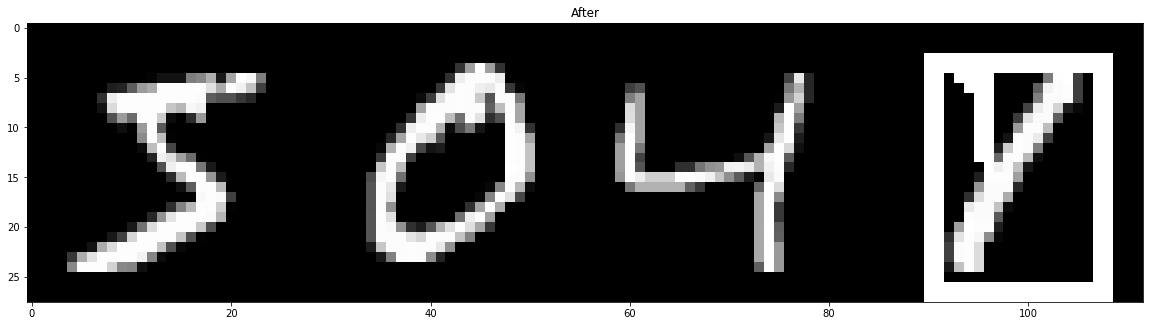

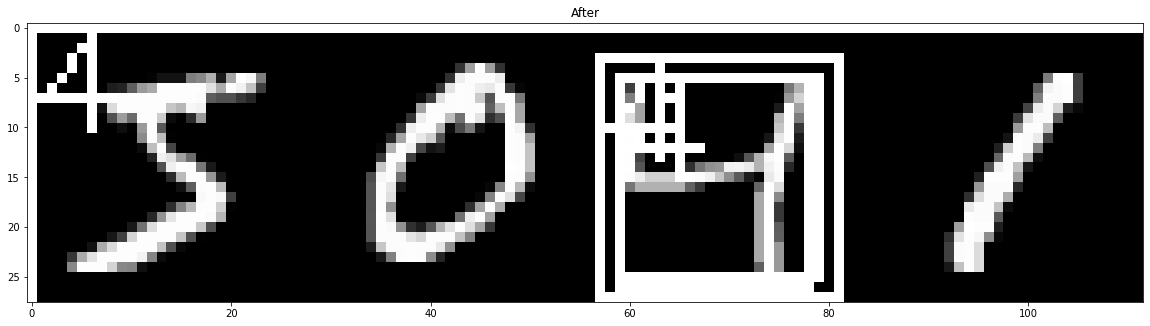

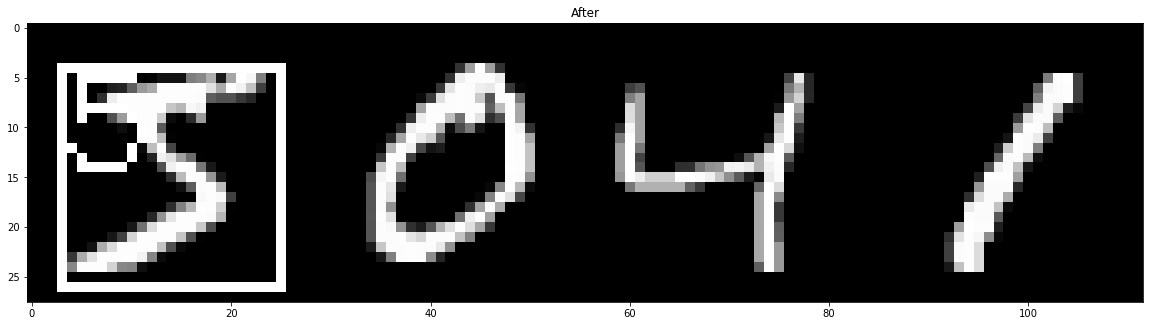

In [6]:
# Ritvik19/mnist-net is a convnet trained on mnist data read more: https://huggingface.co/Ritvik19/mnist-net
model = SelectiveSearchObjectDetection('Ritvik19/mnist-net', **kwargs)
preds = model(orig)
print("Predictions: ", preds)